### 숫자 인식, CNN

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

In [7]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
width=28
height=28

print('x_train:', x_train.shape)
# 전결합층은 1차원 형태의 나열된 데이터여야함.
x_train = x_train.reshape(x_train.shape[0], width * height).astype('float32') / 255 # 60000행  X 784열
print('x_train:', x_train.shape)

x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784


x_train: (60000, 28, 28)
x_train: (60000, 784)


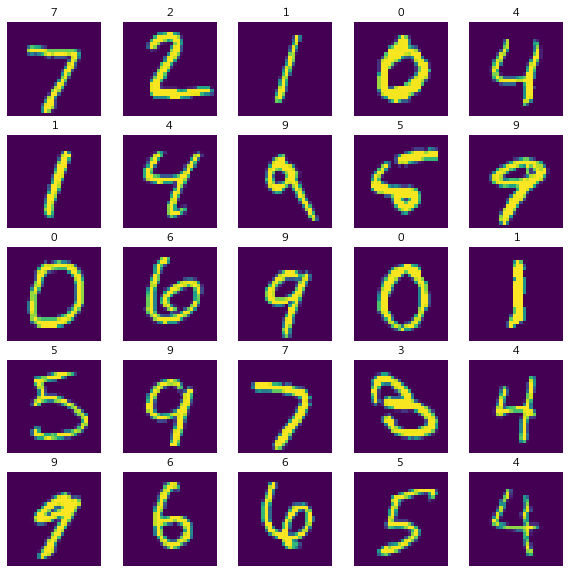

In [8]:
# 데이터 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row * plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i // plt_row, i % plt_col] # 행열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 2차원 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = y_test[i] 
        
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

In [9]:
# 홀수는 1, 짝수는 0
print(y_test[0:3])
y_train = to_categorical(y_train, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)
print(y_test.shape)
print(y_test[0:3])

[7 2 1]
(10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
# 데이터 준비
(x_train, y_train), (x_test, y_test) = mnist.load_data()
width=28
height=28

# 데이터가 0 부터 255로 구성되어 있음으로 255로 나누어서 정규화
# 28 x 28 필셀의 흑백이미지(1) 60000장 구조 생성
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
# 28 x 28 필셀의 흑백이미지(1) 10000장 구조 생성
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0

# 데이터셋 전처리 : 홀수는 1, 짝수는 0으로 변환
# 0: 0, 2, 4, 6, 8
# 1: 1, 3, 5, 7, 9
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (28, 28, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 25%만 사용, 4개중에 최대값 1개만 다음 레이어로 전달
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=1)
start = time.time()
# 장비 속도가 느려 3번만 진행
hist = model.fit(x_train, y_train, validation_split = 0.33, 
                 shuffle=True, epochs=3, 
                 batch_size=50, callbacks=[early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu: 265 초
# gpu: 30 초

Train on 40199 samples, validate on 19801 samples
Epoch 1/3
40199/40199 [==============================] - 15s 376us/sample - loss: 0.2717 - accuracy: 0.9132 - val_loss: nan - val_accuracy: 0.9779
Epoch 2/3
40199/40199 [==============================] - 8s 199us/sample - loss: 0.0865 - accuracy: 0.9737 - val_loss: nan - val_accuracy: 0.9812
Epoch 3/3
40199/40199 [==============================] - 8s 193us/sample - loss: 0.0675 - accuracy: 0.9794 - val_loss: 0.0469 - val_accuracy: 0.9851
Runtime: 30.97 초


In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 16)         

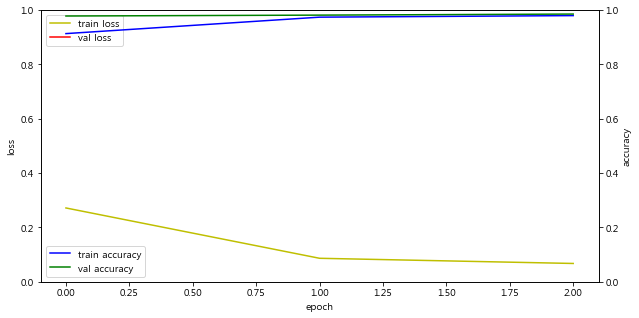

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 왼쪽 y축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y축 레이블, 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.033348653963501645 /정확도: 98.90000224113464 %


In [14]:
model.save('./Mnist3_cnn.h5')

In [15]:
model = load_model('./Mnist3_cnn.h5')

In [16]:
yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

[[7.11304651e-08 8.78764173e-09 6.51986170e-07 6.94983146e-06
  5.14381693e-09 1.24960726e-08 1.57268365e-11 9.99974966e-01
  4.60573668e-09 1.73675635e-05]
 [2.74573466e-07 9.42224578e-05 9.99905229e-01 3.99717557e-08
  3.52803808e-09 4.28748210e-13 1.15616231e-07 1.02408180e-08
  1.23689048e-07 8.98833230e-11]
 [5.20331696e-07 9.99733150e-01 4.80798053e-06 2.79097861e-07
  1.96385168e-04 5.25566179e-07 8.30999579e-06 4.86879326e-05
  3.19220612e-06 4.07109292e-06]
 [9.97888744e-01 6.54389396e-07 3.23814420e-05 2.56762604e-07
  6.33018118e-08 1.63948084e-06 2.05660937e-03 2.03645186e-06
  5.96530253e-06 1.15992198e-05]
 [4.29487779e-10 1.13601743e-07 2.38778721e-08 8.28543811e-09
  9.99969721e-01 1.20186678e-08 2.68555112e-07 2.22431382e-07
  1.04493175e-07 2.95641184e-05]
 [5.32231006e-08 9.99950647e-01 2.89403317e-07 4.33263736e-09
  4.29822430e-05 9.94555993e-09 1.75193179e-07 5.16634327e-06
  1.11246401e-07 7.32076330e-07]
 [7.96719402e-09 4.86595905e-04 1.18476157e-06 9.05475190e

In [17]:
cnt = 0
for i in range(10): # 0 ~ 9
    title = str(np.argmax(y_test[i])) + ' / ' + str(np.argmax(yp[i]))
    print(title)


7 / 7
2 / 2
1 / 1
0 / 0
4 / 4
1 / 1
4 / 4
9 / 9
5 / 5
9 / 9


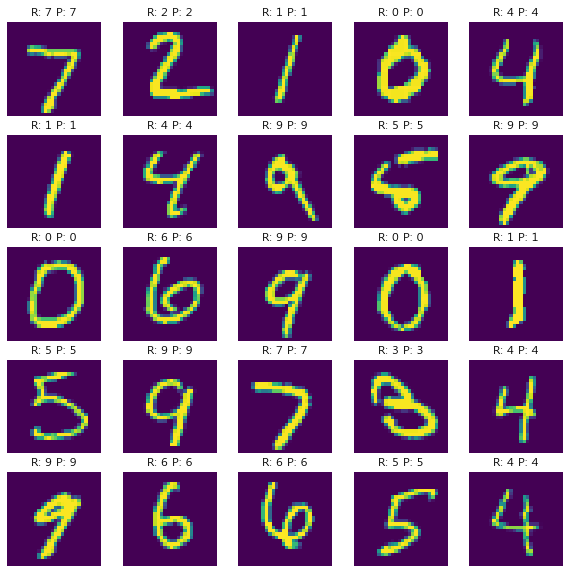

In [18]:
# 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()


## evaluation loss and_metrics ##
손실값: 0.0333486531830742  정확도: 98.90000224113464


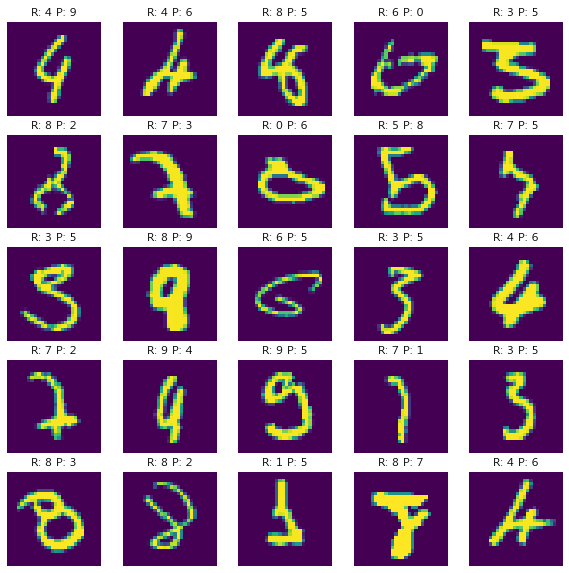

In [19]:
# 오답 이미지만 출력
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('## evaluation loss and_metrics ##')
print('손실값:',loss_and_metrics[0], ' 정확도:', (loss_and_metrics[1] * 100))

yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    
    if np.argmax(y_test[i]) == np.argmax(yhat_test[i]):
        i += 1
        continue # 정답일 경우 출력 안함.
    
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()
